This notebook aims at estimating the convergence rate of the fastPLN algorithm with respect to $p$. We will take a sample of size $n= 2000$. 

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
def show(model,name_doss , threshold, threshold_bis, save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    print('threshold :', threshold)
    first = np.argmin(np.array(model.deltas)>threshold)
    sec = np.argmin(np.array(model.norm_grad_M)>threshold_bis)
    if first == 0 : 
        first = len(model.running_times)-1
    if sec == 0 : 
        sec = len(model.running_times)- 1
        
    first = min(sec, first)
    
    first_time = model.running_times[first]
    sec_time = model.running_times[sec]
    fig,ax = plt.subplots(5,1,figsize = (15,15))

    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    
    
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].axvline(first_time, c = 'red', label = 'threshold')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].axvline(first_time, c = 'red', label = 'threshold')
    ax[1].legend()
    
    
    # plot the L1 norm of the gradients. 
    ax[2].plot(abscisse, model.deltas, label = 'deltas')
    ax[2].set_title('criteria')
    ax[2].legend()
    
    ax[2].axvline(first_time, c = 'red', label = 'threshold')
    ax[2].axhline(threshold, c = 'red', label = 'threshold')
    ax[2].set_yscale('log')
    
    ax[3].plot(abscisse, model.norm_grad_M, label = ' norm grad M ')
    ax[3].set_yscale('log')
    ax[3].axvline(sec_time, c = 'red', label = 'threshold')
    ax[3].legend()
    
    ax[4].plot(abscisse, model.norm_grad_S, label = ' norm grad S')
    ax[4].set_yscale('log')
    ax[4].legend()
    
    '''
    
    #here we plot the variance for the 3 integrals. We set a threshold from which we consider that the integral 
    # is misestimate if the variance of the weights is above. 
    threshold = 0.9
    # integral for beta 
    ax[4].scatter( np.linspace(0,abscisse[-1], model.var_weights['beta'].shape[0]), model.var_weights['beta'],s = 1, label = 'variance of the weights for beta', c = 'black')
    percentage_bad_beta = np.sum(model.var_weights['beta']>threshold)/(model.var_weights['beta'].shape[0])
    ax[4].axhline(model.acc, c = 'red', label = 'reference')
    ax[4].set_title('Variance beta, pourcentage of bad approximations : '+ str(np.round(percentage_bad_beta,3)))
    ax[4].set_yscale('log')
    ax[4].legend()
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()
    


In [3]:
import math
import time


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.linalg as TLA
from tqdm import tqdm
import pandas as pd

from fastPLNmodels.utils import init_C, init_M, init_Sigma, Poisson_reg, log_stirling, batch_log_P_WgivenY, MSE
from fastPLNmodels.utils import refined_MSE, RMSE, build_block_Sigma, sample_PLN
from fastPLNmodels.VRA import SAGARAD, SAGRAD, SVRGRAD 

if torch.cuda.is_available():
    device = torch.device('cuda')
else : 
    device = torch.device('cpu')
    
    

def ELBO(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''Compute the ELBO (Evidence LOwer Bound. See the doc for more details 
    on the computation
    
    Args: 
        Y: torch.tensor. Samples with size (n,p)
        0: torch.tensor. Offset, size (n,p)
        covariates: torch.tensor. Covariates, size (n,d)
        M: torch.tensor. Variational parameter with size (n,p)
        S: torch.tensor. Variational parameter with size (n,p)
        Sigma: torch.tensor. Model parameter with size (p,p)
        beta: torch.tensor. Model parameter with size (d,p)
    Returns: 
        torch.tensor of size 1, with a gradient. The ELBO. 
    '''
    n,p = Y.shape
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum( torch.multiply(Y, OplusM)  
                     -torch.exp(OplusM+SrondS/2) 
                     +1/2*torch.log(SrondS)
                   )
    DplusMmoinsXB2 = torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        DplusMmoinsXB2
                                    )
                          )
    tmp -= n/2*torch.log(torch.det(Sigma))
    tmp -= torch.sum(log_stirling(Y))
    tmp += n*p/2#*(n + (n-1)*math.log(2*math.pi)) 
    return tmp

    
class fastPLN():
    '''Implement the variational algorithm infering the parameters of the PLN model,
    with a closed form for the M step and a gradient step for the VE step. Any value of n 
    and p can be taken.
    '''
    def __init__(self): 
        '''Defines some usefuls lists and variables for the object. A deeper initalization is done 
        in the init_data() func, once the dataset is available.
        '''
        self.old_loss = 1
        # some lists to store some stats
        self.running_times = list()
        self.window = 3
        self.deltas = [1]*self.window
        self.normalized_ELBOs = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        
   
    def init_data(self, Y, O, covariates, good_init): 
        '''Initialize the parameters with the right shape given the data. 
        
        Args: 
              Y: pd.DataFrame of size (n, p). The counts
              O: pd.DataFrame of size (n,p). the offset
              covariates: pd.DataFrame of size (n,p)
        Returns:
            None but initialize some useful data. 
        '''
        #known variables
        self.Y = torch.from_numpy(Y.values).to(device)
        self.O = torch.from_numpy(O.values).to(device)
        self.covariates = torch.from_numpy(covariates.values).to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]
        if good_init : 
            print('Initialization ...') 
            #model parameter 
            poiss_reg = Poisson_reg()
            poiss_reg.fit(self.Y, self.O, self.covariates)
            self.beta = torch.clone(poiss_reg.beta.detach()).to(device)
            self.Sigma =  init_Sigma(self.Y, self.O, self.covariates, self.beta).to(device) 
            # Initialize C in order to initialize M. 
            self.C = TLA.cholesky(self.Sigma).to(device)
            self.M = init_M(self.Y, self.O, self.covariates, self.beta,self.C, 300, 0.1) 
            self.M.requires_grad_(True)
            print('Initialization finished')
        else:
            self.beta = torch.randn((self.d,self.p))
            self.Sigma = torch.diag(torch.ones(self.p))
            self.M = torch.ones(self.n, self.p)

        # No better initialization possible for S
        self.S = 1/2*torch.ones((self.n,self.p)).to(device)
        
    
    def compute_ELBO(self): 
        '''Compute the ELBO with the parameter of the model.'''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    
    def fit(self,Y,O,covariates, N_iter_max= 200, tol = 1e-8,
            optimizer = torch.optim.Rprop, lr = 0.1,good_init = True, verbose = False): 
        '''Main function of the class. Infer the best parameter Sigma and beta given the data.
        
        Args:
            Y: pd.DataFrame of size (n, p). The counts
            O: pd.DataFrame of size (n,p). the offset
            covariates: pd.DataFrame of size (n,p)
            N_iter_max: int. The maximum number of iteration you are ready to do.
                Default is 200. 
            tol_delta: non negative float. Criterion for the model (Default is None).
                If tol_delta is None, then we will set it as 1/(2*p). If the RMSE 
                between the old parameters and the new ones are lower than tol_delta, 
                the algorithm will stop. 
            tol_RMSE_M_grad: non negative float. Criterion for the model (Default is 0.1). 
                If the RMSE of the gradient of M is lower than tol_RMSE_M_grad, the 
                algorithm will stop. 
            optimizer: objects that inherits from torch.optim. The optimize you want. 
                Default is torch.optim.Rprop.
            lr: positive float. The learning rate of the optimizer. Default is 0.1.
            good_init: bool. If True, we will do a smart initialization instead of 
                a random initialization. Default is True. 
            verbose: bool. If True, will print some stats during the fitting. Default is 
                False. 
            
        Returns: 
            None but update the parameter C and beta of the object.
        '''
    
        
        self.t0 = time.time()
        #initialize the data
        self.init_data(Y,O,covariates, good_init)
        self.optimizer = optimizer([self.S,self.M], lr = lr)
        stop_condition = False 
        i = 0
        self.old_beta = torch.clone(self.beta.detach())
        self.old_Sigma = torch.clone(self.Sigma.detach())
        delta = 2*tol 
        while i < N_iter_max and stop_condition == False: 
            # VE step
            self.optimizer.zero_grad()
            self.M.grad = -self.grad_M()
            self.S.grad = -self.grad_S()
            self.optimizer.step()
            # M step
            self.beta = self.closed_beta()
            self.Sigma = self.closed_Sigma()
            self.MSE_Sigma_list.append(MSE(self.Sigma-Sigma_sampling).item())
            self.MSE_beta_list.append(MSE(self.beta-true_beta).item())
            
            # Keep records
            self.normalized_ELBOs.append( -1/self.n*self.compute_ELBO().item())
            self.running_times.append(time.time()-self.t0)
            # Criterions
            if i > self.window -1: # To be sure we have seen enough data
                delta = abs(self.normalized_ELBOs[-1]-self.normalized_ELBOs[-1-self.window])
                self.deltas.append(delta)
            # condition to see if we have reached the tolerance threshold
            if  delta < tol :
                stop_condition = True 
            # print some stats if we want to
            if i%10 == 0 and verbose : 
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('Delta : ', delta)
            i += 1

        if stop_condition : 
            print('Last delta: {},  reached in {} iterations'.format(delta, i))
        else : 
            print('Maximum number of iterations reached : ', N_iter_max, 'last delta = ', delta)

    def grad_M(self):
        '''Compute the gradient of the ELBO with respect to M'''
        grad = self.Y - torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        grad -= torch.mm(self.M-torch.mm(self.covariates,self.beta), torch.inverse(self.Sigma))
        return grad 

    def grad_S(self): 
        '''Compute the gradient of the ELBO with respect to S'''
        grad = torch.div(1,self.S)
        grad -=torch.multiply(self.S, torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2))
        grad -=torch.mm(self.S, torch.diag(torch.diag(torch.inverse(self.Sigma))))
        return grad

    def closed_Sigma(self):
        '''Closed form for Sigma for the M step.'''
        n,p = self.M.shape
        MmoinsXB = self.M-torch.mm(self.covariates,self.beta)
        
        closed = torch.mm(MmoinsXB.T,MmoinsXB)
        closed +=torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0))
        return 1/(n)*closed
    def closed_beta(self): 
        '''Closed form for beta for the M step.'''
        ## a améliorer l'inverse !
        
        return torch.mm(
                        torch.mm(
                                torch.inverse(torch.mm(
                                                    self.covariates.T,
                                                    self.covariates)),
                                self.covariates.T),
                        self.M)

    def show_Sigma(self):
        '''Simple method that displays Sigma to see the global structure.'''
        sns.heatmap(self.Sigma.detach().cpu().numpy())
        plt.show()
    def init_M(self, N_iter, lr, eps = 7e-3):
        '''Initialization for the variational parameter M. Basically, we take 
        the mode of the log_posterior as initialization.
        
        Args: 
            N_iter: int. The maximum number of iteration you are ready to 
                do to find the mode. 
            lr: positive float. The learning rater of the optimizer. A good 
        '''
        def batch_un_log_posterior(W): 
            return batch_log_P_WgivenY(self.Y, self.O, self.covariates,  W, self.C, self.beta) 
        self.batch_un_log_posterior = batch_un_log_posterior
        W = torch.randn(self.n,self.p)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        criterion = 2*eps
        old_W = torch.clone(W)
        keep_condition = True
        while  i < N_iter_max and keep_condition: 
            loss = -torch.mean(self.batch_un_log_posterior(W))
            loss.backward()
            optimizer.step()
            crit = torch.max(torch.abs(W-old_W))
            optimizer.zero_grad()
            if crit<eps and i > 2 : 
                keep_condition = False 
            old_W = torch.clone(W)
            i+=1
        print('nb iteration to find the mode: ', i)
        return W
    
    
    def show(self,name_doss = '' ,  save = False):
        '''displays some useful stats of the model. 

        args : 
            'model' fastPLN object where you have called model.fit_IMPS()
            'name_doss' : str. the name of the file you want to save the graphic. 
            'save' : bool. If True, the graphic will be saved. If false, won't be saved. 

        returns : 
                None but displays the figure. It can also save the figure if save = True. 
        '''
        fig,ax = plt.subplots(4,1,figsize = (10,10))
        abscisse = self.running_times
        plt.subplots_adjust(hspace = 0.4)
        
        ax[0].plot(abscisse, self.normalized_ELBOs, label = 'Negative ELBO')
        ax[0].set_title('Negative ELBO')
        ax[0].set_yscale('log')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('ELBO')
        ax[0].legend()
    
        ax[1].plot(abscisse, self.deltas, label = 'Delta')
        ax[1].set_yscale('log')
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('Delta')
        ax[1].set_title('Increments')
        ax[1].legend()
        
        ax[2].plot(abscisse, self.MSE_Sigma_list, label = 'Sigma')
        ax[2].set_yscale('log')
        ax[2].legend()
        
        
        ax[3].plot(abscisse, self.MSE_beta_list, label = 'Sigma')
        ax[3].set_yscale('log')
        ax[3].legend()
        
        if save : 
            plt.savefig(name_doss)
        plt.show()
        self.show_Sigma()
            
    def __str__(self):
        '''Show the stats of the model and Sigma'''
        print('Last ELBO :', -self.normalized_ELBOs[-1])
        self.show()
        return ''
        







In [4]:
def RMSE(mat):
    return torch.sqrt(torch.mean(mat**2))
def MSE(mat):
    return torch.mean(mat**2)

In [68]:
d = 2
n = 100;  p = 3
q = 3

In [69]:
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
#true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
#true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/1.5

covariates = torch.randn((n,d))/1
O =  1+torch.zeros((n,p))
Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)

In [70]:
torch.max(Y)

tensor(32.)

In [71]:
Y = pd.DataFrame(Y.cpu().numpy())
covariates = pd.DataFrame(covariates.cpu().numpy())
O = pd.DataFrame(O.cpu().numpy())

In [72]:
model = fastPLN()
model.fit(Y,O,covariates, 200, verbose = False, tol = 1e-1)

Initialization ...
nb iteration to find the mode:  45
Initialization finished
Last delta: 0.0564947920182135,  reached in 12 iterations


Last ELBO : -6.156711270147139


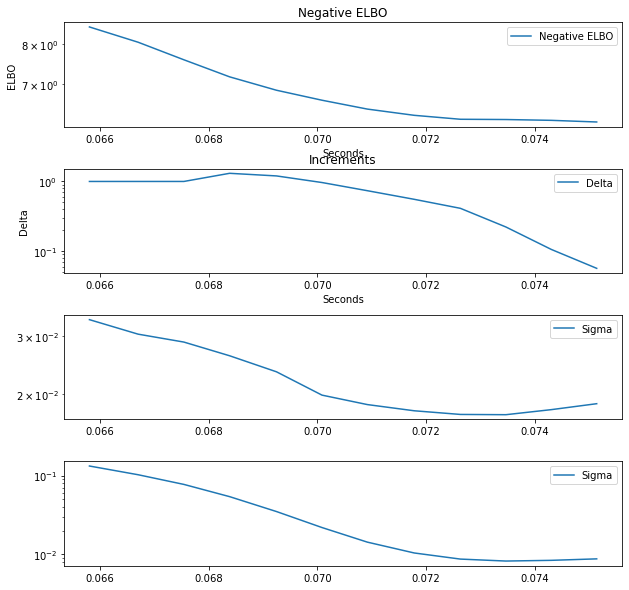

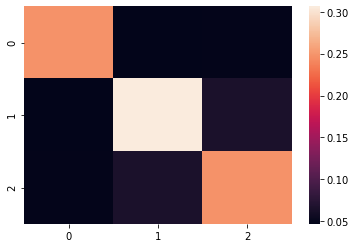

In [73]:
print(model)

In [74]:
from fastPLNmodels.models import log_likelihood
from fastPLNmodels.utils import C_from_Sigma

new_C = C_from_Sigma(model.Sigma, p).detach()
print('log likelihood:', log_likelihood(Y,O,covariates, new_C, model.beta.detach()))

Intialization ...
Initalization done
log likelihood: tensor(-6.1016)


In [11]:
from fastPLNmodels.models import IMPS_PLN
imps = IMPS_PLN(q)
imps.fit(Y,O,covariates, acc = 0.005, lr = 0.01)

device  cpu
Intialization ...
Initalization done


 44%|████▎     | 87/200 [00:04<00:05, 21.33it/s]

Algorithm stopped after  87  iterations


In [132]:
def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta):
    '''compute the ELBO with a PCA parametrization'''
    n = Y.shape[0]
    q = C.shape[1]
    # Store some variables that will need to be computed twice 
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    # Next, we add the four terms of the ELBO_PCA 
    first = torch.sum(torch.multiply(Y,A))
    second = torch.sum(-torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T)))
    third = 1/2*torch.sum(torch.log(SrondS))
    fourth = torch.sum(-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    log = torch.sum(log_stirling(Y))
    return first +second + third + fourth - log +n*q/2  

class fastPLNPCA():
    def __init__(self,q): 
        '''Defines some usefuls lists and variables for the object. A deeper initalization is done 
        in the init_data() func, once the dataset is available.
        Args:
            q: int. The dimension of the latent space. 
        Returns: 
            a fastPLNPCA object
        '''
        self.old_loss = 1
        self.q = q
        # some lists to store some stats
        self.fitted = False
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.window = 3
        self.deltas = [1]*self.window
        self.normalized_ELBOs = list()
        
    def init_data(self,Y, O, covariates,  good_init): 
        '''Initialize the parameters with the right shape given the data. 
        
        Args: 
            Y: pd.DataFrame of size (n, p). The counts
            O: pd.DataFrame of size (n,p). the offset
            covariates: pd.DataFrame of size (n,p)
            good_init: bool. Tells if we want to do a good initialization (not random).
                  Takes some time. 
        Returns:
            None but initialize some useful data.'''

        self.ELBO_list = list()
        self.running_times = list()
        
        if self.fitted == False: 
            self.Y = torch.from_numpy(Y.values).to(device)
            self.O = torch.from_numpy(O.values).to(device)
            self.covariates = torch.from_numpy(covariates.values).to(device)
            self.n, self.p = self.Y.shape
            self.d = self.covariates.shape[1]
            # If we want to do a good initialization
            print('Initialization ...')
            if good_init : 
                poiss_reg = Poisson_reg()
                poiss_reg.fit(self.Y,self.O,self.covariates)
                # Model parameter 
                self.beta = torch.clone(poiss_reg.beta.detach()).to(device) 
                self.C = init_C(self.Y, self.O, self.covariates, self.beta, self.q).to(device)
                # Variational parameter
                self.M = init_M(self.Y, self.O, self.covariates, self.beta,self.C, 300, 0.1)
            else: 
                self.C = torch.randn((self.p,self.q)).to(device)
                self.beta = torch.randn((self.d,self.p)).to(device)
                self.M = torch.randn((self.n,self.q)).to(device) 
            print('Initialization finished')
            # Can't do any further initialization
            self.S = torch.randn((self.n,self.q)).to(device)
            # Set some gradients for optimization
            self.beta.requires_grad_(True)
            self.M.requires_grad_(True)
            self.S.requires_grad_(True)
            self.C.requires_grad_(True)

    
    def compute_ELBO_PCA(self):
        '''Compute the ELBO of the PCA parametrisation with the parameter of the model.'''
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    
    def fit(self, Y, O, covariates, N_iter_max = 800, tol = 0.0002, optimizer = torch.optim.Rprop,
            lr = 0.1, good_init = True, verbose = False):
        '''Main function of the class. Infer the best parameter C and beta given the data.
        
        Args:
            Y: pd.DataFrame of size (n, p). The counts
            O: pd.DataFrame of size (n,p). The offset
            covariates: pd.DataFrame of size (n,p). 
            N_iter_max: int. The maximum number of iteration you are ready 
                to do (Default is 8000).  
            tolerance: non negative float. Criterion for the model (Default is 0.0002).
                If the RMSE between the old parameters and the new ones are 
                lower than tol_delta, the algorithm will stop. 
            optimizer: objects that inherits from torch.optim. The optimize you want. 
                Default is torch.optim.Rprop.
            lr: positive float. The learning rate of the optimizer. Default is 0.1.
            good_init: Bool. If True, will do a good initialization. Takes some time. 
                Default is True. 
            verbose: bool. If True, will print some stats during the fitting. Default is 
                False. 
        Returns: 
            None but update the parameter C and beta of the object.
        '''
        self.t0 = time.time()
        #initialize the data
        self.init_data(Y, O, covariates, good_init)
        self.optimizer = optimizer([self.beta, self.C, self.M, self.S], lr = lr)
        stop_condition = False 
        i = 0
        delta = 2*tol 
        while i < N_iter_max and stop_condition == False : 
            self.optimizer.zero_grad()
            loss = -self.compute_ELBO_PCA()
            loss.backward()
            self.old_beta = torch.clone(self.beta)
            self.old_Sigma = torch.clone(self.get_Sigma())
            self.optimizer.step()
            # Compute the criterion
            self.MSE_Sigma_list.append(MSE(self.get_Sigma()-Sigma_sampling).item())
            self.MSE_beta_list.append(MSE(self.beta-true_beta).item())
            # Keep records
            self.normalized_ELBOs.append(1/self.n*loss.item())
            # Criterions
            
            if i > self.window -1: # To be sure we have seen enough data
                delta = abs(self.normalized_ELBOs[-1]-self.normalized_ELBOs[-1-self.window])
                self.deltas.append(delta)
            # Condition to see if we have reach the tolerance threshold
            if  abs(delta) < tol :
                stop_condition = True 
            # Print some stats if we want to
            if i%100 == 0 and verbose : 
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('Delta : ', delta)
            # Keep track of the time 
            self.running_times.append(time.time()-self.t0)
            i+=1
        if stop_condition : 
            print('Tolerance {} reached in {} iterations'.format(tol, i))
        else : 
            print('Maximum number of iterations reached : ', N_iter_max, 'last delta = ', delta)
        self.fitted = True
    def get_Sigma(self): 
        '''Return the parameter Sigma of the model, that is CC^T'''
        return self.C@(self.C.T)
    
    def gradPCA_beta(self):
        '''Compute the gradient of the ELBO with respect to beta. Sanity check'''
        matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first_term = torch.mm(self.covariates.T,self.Y)
        second_term = -1/2*torch.mm(
                             self.covariates.T,
                             torch.exp(self.O+torch.mm(
                                                       self.covariates,
                                                       self.beta
                                                      )
                                         +torch.mm(self.M,matC.T)+1/2*torch.mm(SrondS,CrondC.T))
                             )
        return first_term+second_term
    
    def gradPCA_M(self):
        '''Compute the gradient of the ELBO with respect to M. Sanity check'''
        CrondC = torch.multiply(self.C,self.C)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,self.C.T)
        first = torch.mm(self.Y,self.C)
        second = -1/2*torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),self.C)
        third = -self.M
        return first + second+third
    def gradPCA_S(self):
        '''Compute the gradient of the ELBO with respect to S. Sanity check'''
        matC = self.C
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        first = -1/2*torch.multiply(self.S,torch.mm(torch.exp(A+1/2*torch.mm(SrondS,CrondC.T)),CrondC))
        second = torch.div(1,self.S)
        third = -self.S
        return first + second +third
    
    def gradPCA_C(self):
        '''Compute the gradient of the ELBO with respect to C. Sanity check'''
        matC  = self.C 
        CrondC = torch.multiply(matC,matC)
        SrondS = torch.multiply(self.S,self.S)
        first = torch.mm(self.Y.T,self.M) 
        A = self.O +torch.mm(self.covariates,self.beta) + torch.mm(self.M,matC.T)
        exp = torch.exp(A + 1/2*torch.mm(SrondS,CrondC.T))
        second = -1/2*torch.mm(exp.T,self.M)-1/2*torch.multiply(matC,torch.mm(exp.T,SrondS))
        return first + second

    def show(self,name_doss='Stat_model', save = False):
        '''displays some useful stats of the model. 

        args : 
            'model' fastPLNPCA object where you have called model.fit_IMPS()
            'name_doss' : str. the name of the file you want to save the graphic.
                Default is 'Stat_model'. 
            'save' : bool. If True, the graphic will be saved. If false, won't be saved. 

        returns : 
                None but displays the figure. It can also save the figure if save = True. 
        '''

        fig,ax = plt.subplots(4,1,figsize = (15,12))
        abscisse = self.running_times
        plt.subplots_adjust(hspace = 0.4)
        # Plot the negative ELBO minus the maximum for a nice plot
        ax[0].plot(abscisse[20:], np.array(self.normalized_ELBOs)[20:], label = 'ELBO')
        ax[0].legend()
        ax[0].set_yscale('log')
        ax[0].set_title('ELBO')
        ax[0].set_ylabel('ELBO')
        ax[0].set_xlabel('Seconds')
        
        # Plot the criteria of the algorithm. 
        ax[1].plot(abscisse, self.deltas, label = 'deltas')
        ax[1].set_yscale('log')
        ax[1].legend()
        ax[2].plot(abscisse, self.MSE_Sigma_list, label = 'Sigma')
        ax[2].set_yscale('log')
        ax[2].legend()
        
        
        ax[3].plot(abscisse, self.MSE_beta_list, label = 'beta')
        ax[3].set_yscale('log')
        ax[3].legend()

        ax[0].legend()
        if save : 
            plt.savefig(name_doss)
        plt.show()
        sns.heatmap(self.get_Sigma().detach())
        plt.show()



In [171]:
d = 2
n = 1000;  p = 400
q = 5

In [172]:
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
#true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
#true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.rand((d, p))/1.5

covariates = torch.randn((n,d))/1
O =  1+torch.zeros((n,p))
Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)

In [173]:
Y = pd.DataFrame(Y.cpu().numpy())
covariates = pd.DataFrame(covariates.cpu().numpy())
O = pd.DataFrame(O.cpu().numpy())

In [174]:
Y = pd.read_csv('Y_test')
O = pd.read_csv('O_test')
covariates = pd.read_csv('cov_test')
Sigma_sampling = torch.from_numpy(pd.read_csv('true_Sigma_test').values)
true_beta = torch.from_numpy(pd.read_csv('true_beta_test').values)

In [175]:
pca = fastPLNPCA(q)
pca.fit(Y,O,covariates,tol= 1e-3, verbose = True)

Initialization ...
nb iteration to find the mode:  87
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0.002
Iteration number:  100
-------UPDATE-------
Delta :  0.013153766673866585
Iteration number:  200
-------UPDATE-------
Delta :  0.0027935458614223307
Iteration number:  300
-------UPDATE-------
Delta :  0.0050506635753890805
Tolerance 0.001 reached in 390 iterations


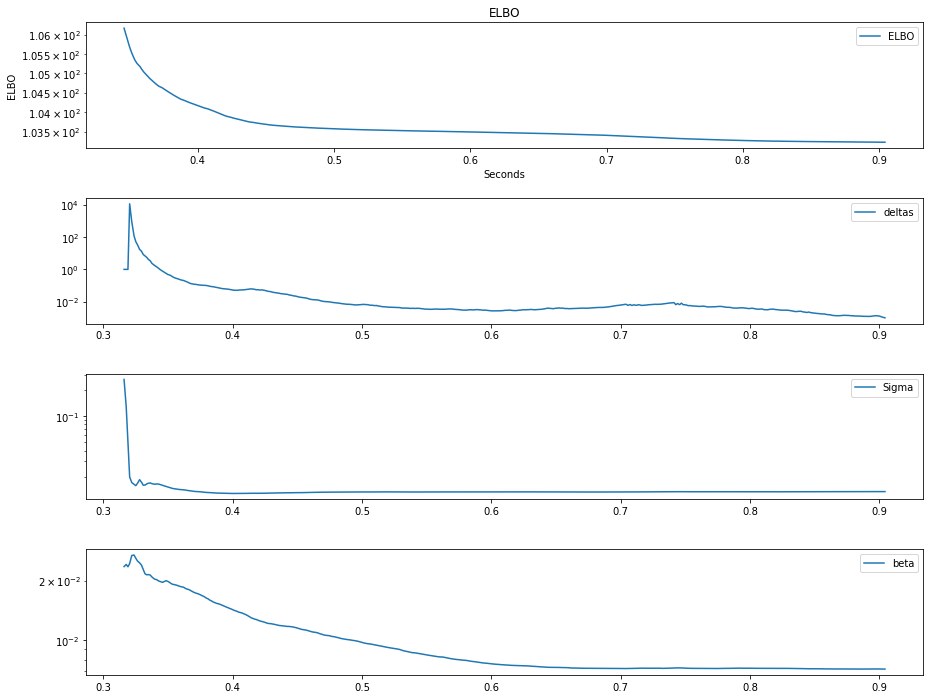

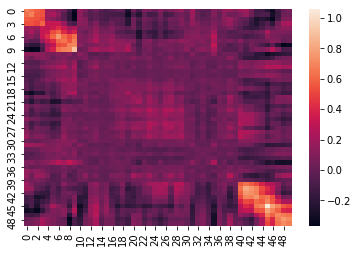

In [176]:
pca.show()

In [177]:
print('MSE beta', pca.MSE_beta_list[-1])
print('MSE Sigma', pca.MSE_Sigma_list[-1])

MSE beta 0.007169626825076534
MSE Sigma 0.013461954586105006


In [162]:
print('MSE beta', pca.MSE_beta_list[-1])
print('MSE Sigma', pca.MSE_Sigma_list[-1])

MSE beta 0.007338574846284104
MSE Sigma 0.013187060193985065
